In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [167]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')



In [168]:
df = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/train.csv')
df.head(10)

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1
5,0.1318,90000.0,3.48,7,0,0,2903,31,0,0,0,19548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7000,7000.0,0.0,1,7,236.47,0.854,0.0,0.0,1330.30,660,664,0
6,0.0791,60000.0,17.34,0,0,0,20399,35,0,0,0,117320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,20000,20000.0,0.0,1,18,625.90,0.369,0.0,0.0,2567.44,750,754,0
7,0.0975,79600.0,15.97,3,0,1,6481,17,0,0,0,18757,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,23800,23800.0,0.0,1,7,765.17,0.745,0.0,0.0,3006.76,680,684,0
8,0.0789,150000.0,7.36,1,0,0,15827,38,0,0,543,367504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,16000,16000.0,0.0,1,19,500.58,0.334,0.0,0.0,1286.38,665,669,0
9,0.0999,95000.0,25.78,0,1,0,17870,37,0,0,0,273776,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,24,258.10,0.764,0.0,0.0,796.59,665,669,0


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

In [170]:
# emp_length feature decoding
for i in range(1, 13):
    df.loc[df[f'emp_length{i}'] == 1, f'emp_length{i}'] = i

df['emp_length'] = df['emp_length1']

for i in range(2, 13):
    df['emp_length'] += df[f'emp_length{i}']

for i in range(1,13): 
    df = df.drop(f'emp_length{i}', axis=1)


In [171]:
# purpose feature decoding
for i in range(1, 15):
    df.loc[df[f'purpose{i}'] == 1, f'purpose{i}'] = i

df['purpose'] = df['purpose1']

for i in range(2, 15):
    df['purpose'] += df[f'purpose{i}']

for i in range(1,15): 
    df = df.drop(f'purpose{i}', axis=1)


In [172]:
# is home_ownership categorical?
home_ownership = []
for i in range(1, 7):
    home_ownership.append(f'home_ownership{i}')
df.value_counts(home_ownership)

home_ownership1  home_ownership2  home_ownership3  home_ownership4  home_ownership5  home_ownership6
0                1                0                0                0                0                  46612
                 0                0                0                0                1                  42255
                                                                    1                0                  11088
1                0                0                0                0                0                     33
0                0                1                0                0                0                      7
                                  0                1                0                0                      5
dtype: int64

In [173]:
# home_ownership feature decoding
for i in range(1, 7):
    df.loc[df[f'home_ownership{i}'] == 1, f'home_ownership{i}'] = i

df['home_ownership'] = df['home_ownership1']

for i in range(2, 7):
    df['home_ownership'] += df[f'home_ownership{i}']

for i in range(1, 7): 
    df = df.drop(f'home_ownership{i}', axis=1)


In [174]:
# is verification_status categorical?
verification_status = []
for i in range(1, 4):
    verification_status.append(f'verification_status{i}')
df.value_counts(verification_status)

verification_status1  verification_status2  verification_status3
0                     1                     0                       39020
1                     0                     0                       32180
0                     0                     1                       28800
dtype: int64

In [175]:
# verification_status feature decoding
for i in range(1, 4):
    df.loc[df[f'verification_status{i}'] == 1, f'verification_status{i}'] = i

df['verification_status'] = df['verification_status1']

for i in range(2, 4):
    df['verification_status'] += df[f'verification_status{i}']

for i in range(1, 4): 
    df = df.drop(f'verification_status{i}', axis=1)

In [176]:
# is initial_list_status categorical?
initial_list_status = []
for i in range(1, 3):
    initial_list_status.append(f'initial_list_status{i}')
df.value_counts(initial_list_status)

initial_list_status1  initial_list_status2
0                     1                       56557
1                     0                       43443
dtype: int64

In [177]:
# initial_list_status feature decoding
for i in range(1, 3):
    df.loc[df[f'initial_list_status{i}'] == 1, f'initial_list_status{i}'] = i

df['initial_list_status'] = df['initial_list_status1']

for i in range(2, 3):
    df['initial_list_status'] += df[f'initial_list_status{i}']

for i in range(1, 3): 
    df = df.drop(f'initial_list_status{i}', axis=1)

In [178]:
# is mths_since_last_delinq categorical?
mths_since_last_delinq = []
for i in range(1, 12):
    mths_since_last_delinq.append(f'mths_since_last_delinq{i}')
df.value_counts(mths_since_last_delinq)

mths_since_last_delinq1  mths_since_last_delinq2  mths_since_last_delinq3  mths_since_last_delinq4  mths_since_last_delinq5  mths_since_last_delinq6  mths_since_last_delinq7  mths_since_last_delinq8  mths_since_last_delinq9  mths_since_last_delinq10  mths_since_last_delinq11
1                        0                        0                        0                        0                        0                        0                        0                        0                        0                         0                           48932
0                        0                        1                        0                        0                        0                        0                        0                        0                        0                         0                            6009
                                                  0                        0                        0                        0                        0   

In [179]:
# mths_since_last_delinq feature decoding
for i in range(1, 12):
    df.loc[df[f'mths_since_last_delinq{i}'] == 1, f'mths_since_last_delinq{i}'] = i

df['mths_since_last_delinq'] = df['mths_since_last_delinq1']

for i in range(2, 12):
    df['mths_since_last_delinq'] += df[f'mths_since_last_delinq{i}']

for i in range(1, 12): 
    df = df.drop(f'mths_since_last_delinq{i}', axis=1)

In [180]:
# Type modification for Categorical features
df['emp_length'] = df.emp_length.astype('category')
df['purpose'] = df.emp_length.astype('category')
df['home_ownership'] = df.emp_length.astype('category')
df['verification_status'] = df.emp_length.astype('category')
df['initial_list_status'] = df.emp_length.astype('category')
df['mths_since_last_delinq'] = df.emp_length.astype('category')

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   int_rate                    100000 non-null  float64 
 1   annual_inc                  100000 non-null  float64 
 2   dti                         100000 non-null  float64 
 3   delinq_2yrs                 100000 non-null  int64   
 4   inq_last_6mths              100000 non-null  int64   
 5   pub_rec                     100000 non-null  int64   
 6   revol_bal                   100000 non-null  int64   
 7   total_acc                   100000 non-null  int64   
 8   collections_12_mths_ex_med  100000 non-null  int64   
 9   acc_now_delinq              100000 non-null  int64   
 10  tot_coll_amt                100000 non-null  int64   
 11  tot_cur_bal                 100000 non-null  int64   
 12  chargeoff_within_12_mths    100000 non-null  int64   
 13  

In [308]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [309]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [310]:
X_train

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,emp_length,purpose,home_ownership,verification_status,initial_list_status,mths_since_last_delinq
62716,0.1199,65000.0,16.25,1,0,0,5100,22,0,0,1262,85434,0,0,0,9000,8950.0,0.0,1,13,298.89,0.455,0.0,0.0,1277.31,660,664,2,2,2,2,2,2
50120,0.0603,75000.0,14.53,0,0,0,15496,37,0,0,0,188405,0,0,0,18000,18000.0,0.0,1,12,547.84,0.331,0.0,0.0,429.16,745,749,2,2,2,2,2,2
50770,0.1239,23000.0,26.52,0,2,0,16421,13,0,0,0,17582,0,0,0,10000,9950.0,0.0,1,11,334.01,0.538,0.0,0.0,1835.34,665,669,10,10,10,10,10,10
45212,0.1049,62000.0,31.84,0,0,2,8052,17,0,0,301,71583,0,0,1,10000,10000.0,0.0,1,10,324.98,0.624,0.0,0.0,1450.38,660,664,6,6,6,6,6,6
22360,0.1727,55000.0,17.02,0,0,0,10888,18,0,0,0,16773,0,0,0,15000,15000.0,0.0,1,15,536.81,0.589,0.0,0.0,2744.61,665,669,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49496,0.2100,120000.0,3.54,1,3,0,9209,26,0,0,0,9209,1,0,0,12000,12000.0,0.0,0,8,324.65,0.719,0.0,0.0,826.47,685,689,5,5,5,5,5,5
25915,0.1699,32000.0,21.64,0,1,0,8711,7,0,0,0,26355,0,0,0,8000,8000.0,0.0,1,4,285.19,0.702,0.0,0.0,2008.09,665,669,9,9,9,9,9,9
38213,0.0762,32000.0,29.36,0,0,0,8043,13,0,0,0,20285,0,0,0,7250,7250.0,0.0,1,6,225.92,0.359,0.0,0.0,537.89,765,769,9,9,9,9,9,9
74713,0.2100,34000.0,17.33,0,0,0,6993,14,0,0,0,15083,0,0,0,5000,5000.0,0.0,1,3,188.38,0.853,0.0,0.0,1772.01,660,664,10,10,10,10,10,10


In [311]:
# scaling
# feature 중요도가 높은 놈들 scaling 에서 제외 해볼까 ?
cols_to_scale = ['funded_amnt_inv',
       'tot_cur_bal','pub_rec', 'open_acc',  
       'tot_coll_amt', 'total_acc', 
       'delinq_amnt', 'inq_last_6mths',
       'revol_bal','total_rec_late_fee',
       'out_prncp', 'out_prncp_inv', 'delinq_2yrs',
       ]
cat_features = [ 'total_rec_int', 'installment', 'int_rate',  'dti', 'funded_amnt',
                'annual_inc','revol_util',
                'term1', 'tax_liens', 'collections_12_mths_ex_med',
                'fico_range_low', 'fico_range_high'
                'emp_length',
                'acc_now_delinq', 'chargeoff_within_12_mths', 
                'purpose', 'home_ownership', 
                'verification_status', 'initial_list_status', 'mths_since_last_delinq']
scaler = PowerTransformer()

scaler.fit(X_train[cols_to_scale])

X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
# X_train = pd.merge(X_train_scaled, X_train[cat_features], left_index=True, right_index=True, how='left')
# X_train_scaled.join(X_train[cat_features], how='left')

X_valid[cols_to_scale] = scaler.transform(X_valid[cols_to_scale])
# X_valid = pd.merge(X_valid_scaled, X_valid[cat_features], left_index=True, right_index=True, how='left')

In [312]:
X_train.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,emp_length,purpose,home_ownership,verification_status,initial_list_status,mths_since_last_delinq
62716,0.1199,65000.0,16.25,1.942987,-0.855300,-0.468042,-0.756389,-0.069721,0,0,2.314213,0.115717,0,-0.066141,0,9000,-0.416042,-0.263425,1,0.442514,298.89,0.455,-0.015988,-0.015988,1277.31,660,664,2,2,2,2,2,2
50120,0.0603,75000.0,14.53,-0.507629,-0.855300,-0.468042,0.331386,1.065161,0,0,-0.434099,0.800209,0,-0.066141,0,18000,0.667890,-0.263425,1,0.264365,547.84,0.331,-0.015988,-0.015988,429.16,745,749,2,2,2,2,2,2
50770,0.1239,23000.0,26.52,-0.507629,1.401844,-0.468042,0.395459,-1.037625,0,0,-0.434099,-1.061556,0,-0.066141,0,10000,-0.265831,-0.263425,1,0.073061,334.01,0.538,-0.015988,-0.015988,1835.34,665,669,10,10,10,10,10,10
45212,0.1049,62000.0,31.84,-0.507629,-0.855300,2.155304,-0.340092,-0.565413,0,0,2.307695,-0.028138,0,-0.066141,1,10000,-0.258604,-0.263425,1,-0.133597,324.98,0.624,-0.015988,-0.015988,1450.38,660,664,6,6,6,6,6,6
22360,0.1727,55000.0,17.02,-0.507629,-0.855300,-0.468042,-0.042125,-0.459148,0,0,-0.434099,-1.093114,0,-0.066141,0,15000,0.363032,-0.263425,1,0.766025,536.81,0.589,-0.015988,-0.015988,2744.61,665,669,4,4,4,4,4,4


In [313]:
# 하이퍼 파라미터 튜닝
lgbm_clf = LGBMClassifier(tree_method='gpu_hist',
                                gpu_id=0,
                          
                          )

param_grid = {'boosting_type' : ['dart'],
              'eta' : [0.05],
              'max_depth':[8],
            #   'min_child_weight' : [0.001], # 0.001, 0. ... 
              'n_estimators':[350],

              'num_leaves' : [72],  # better acc when the value is less than 2^(max_depth)  default== 31    larger the better(?)
              'min_child_samples' : [27], # default 20,  the larger value can cause underfitting, default==0
            
             # 'gamma' : [0], #0 ~ 1
               
               'reg_alpha' : [0.1], # 0 ~ 1 # 0.1 scored highest yet  default = 0
               'reg_lambda':[0.9], # 0 ~ 1 # 0.9 last value  default == 0
               'is_unbalance' : [True] # 'True' went better
               }

cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=1)

grid_search = GridSearchCV(estimator=lgbm_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='f1_macro',
                           error_score=0)
lgbm_clf_results=grid_search.fit(X_train, y_train)

lgbm_clf_results.best_params_

{'boosting_type': 'dart',
 'eta': 0.05,
 'is_unbalance': True,
 'max_depth': 8,
 'min_child_samples': 27,
 'n_estimators': 350,
 'num_leaves': 72,
 'reg_alpha': 0.1,
 'reg_lambda': 0.9}

In [314]:
# best parameter를 사용하여 prediction 수행
lgbm_clf = LGBMClassifier(boosting_type='dart',
                          eta=lgbm_clf_results.best_params_['eta'],
                          max_depth = lgbm_clf_results.best_params_['max_depth'],
                        #   min_child_weight=lgbm_clf_results.best_params_['min_child_weight'],
                          n_estimators =lgbm_clf_results.best_params_['n_estimators'],
                          num_leaves =lgbm_clf_results.best_params_['num_leaves'],
                          min_child_samples=lgbm_clf_results.best_params_['min_child_samples'],

                          eval_metric='logloss',
                          objective= 'binary' ,


                          reg_alpha=lgbm_clf_results.best_params_['reg_alpha'],
                          #   gamma=lgbm_clf_results.best_params_['gamma'],
                          reg_lambda=lgbm_clf_results.best_params_['reg_lambda'],
                          is_unbalance=lgbm_clf_results.best_params_['is_unbalance'],
                          
                          tree_method='gpu_hist',
                          gpu_id=0,
                          seed=42,
                          )

lgbm_clf.fit(X_train, y_train,
             )

y_pred_lgbm = lgbm_clf.predict(X_valid)

In [315]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob_lgbm = lgbm_clf.predict_proba(X_valid)

print(len(y_pred_prob_lgbm))
y_pred_prob_lgbm

10000


array([[0.77305914, 0.22694086],
       [0.79093917, 0.20906083],
       [0.71736196, 0.28263804],
       ...,
       [0.60988385, 0.39011615],
       [0.92811385, 0.07188615],
       [0.195779  , 0.804221  ]])

In [316]:
# y_valid가 1일 확률 출력
y_pred_prob_lgbm[:,1]

array([0.22694086, 0.20906083, 0.28263804, ..., 0.39011615, 0.07188615,
       0.804221  ])

In [317]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [318]:
# threshold tuning 함수
def Threshold_tuing(model):
    # Threshold조정
    y_pred_prob = model.predict_proba(X_valid)
    f1_by_threshold={}
    for i in np.arange(0.3,0.65,0.001):
        f1_by_threshold[i] = f1_score(y_valid,y_pred_prob[:,1]>i, average='macro')
    plt.plot(np.array(list(f1_by_threshold.values())).astype(float))
    plt.title("F1_score by Threshold",fontsize=15)
    plt.grid(True)
    plt.show()
    print(sorted(list(f1_by_threshold.items()),key=lambda x:x[1],reverse=True)[0])

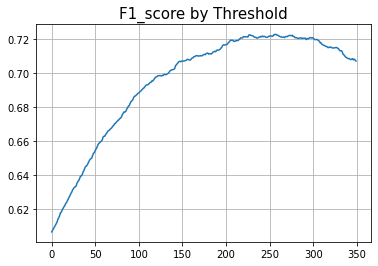

(0.5570000000000002, 0.722763430453681)


In [319]:
Threshold_tuing(lgbm_clf)


정확도: 0.7376
정밀도: 0.5798
재현율: 0.7113
AUC: 0.7308
F1: 0.7164


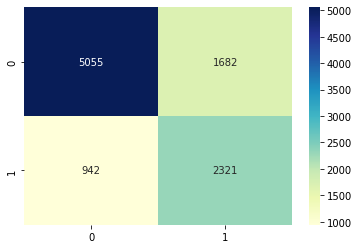

In [297]:


# lgbm 성능 확인
get_clf_eval(y_valid, y_pred_lgbm)


정확도: 0.7488
정밀도: 0.6120
재현율: 0.6644
AUC: 0.7276
F1: 0.7225


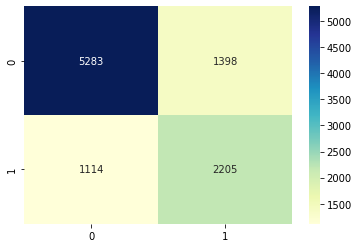

In [320]:
# threshold 변경 및 성능 확인D
get_clf_eval(y_valid, y_pred_prob_lgbm[:,1] > 0.556
             )

In [303]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/sample_submission.csv')
submit.head()

,ID,answer
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [304]:
# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/test.csv')

# emp_length feature decoding
for i in range(1, 13):
    df_test.loc[df_test[f'emp_length{i}'] == 1, f'emp_length{i}'] = i

df_test['emp_length'] = df_test['emp_length1']

for i in range(2, 13):
    df_test['emp_length'] += df_test[f'emp_length{i}']

for i in range(1,13): 
    df_test = df_test.drop(f'emp_length{i}', axis=1)

# purpose feature decoding
for i in range(1, 15):
    df_test.loc[df_test[f'purpose{i}'] == 1, f'purpose{i}'] = i

df_test['purpose'] = df_test['purpose1']

for i in range(2, 15):
    df_test['purpose'] += df_test[f'purpose{i}']

for i in range(1,15): 
    df_test = df_test.drop(f'purpose{i}', axis=1)

# home_ownership feature decoding
for i in range(1, 7):
    df_test.loc[df_test[f'home_ownership{i}'] == 1, f'home_ownership{i}'] = i

df_test['home_ownership'] = df_test['home_ownership1']

for i in range(2, 7):
    df_test['home_ownership'] += df_test[f'home_ownership{i}']

for i in range(1, 7): 
    df_test = df_test.drop(f'home_ownership{i}', axis=1)

# verification_status feature decoding
for i in range(1, 4):
    df_test.loc[df_test[f'verification_status{i}'] == 1, f'verification_status{i}'] = i

df_test['verification_status'] = df_test['verification_status1']

for i in range(2, 4):
    df_test['verification_status'] += df_test[f'verification_status{i}']

for i in range(1, 4): 
    df_test = df_test.drop(f'verification_status{i}', axis=1)

# initial_list_status feature decoding
for i in range(1, 3):
    df_test.loc[df_test[f'initial_list_status{i}'] == 1, f'initial_list_status{i}'] = i

df_test['initial_list_status'] = df_test['initial_list_status1']

for i in range(2, 3):
    df_test['initial_list_status'] += df_test[f'initial_list_status{i}']

for i in range(1, 3): 
    df_test = df_test.drop(f'initial_list_status{i}', axis=1)

# mths_since_last_delinq feature decoding
for i in range(1, 12):
    df_test.loc[df_test[f'mths_since_last_delinq{i}'] == 1, f'mths_since_last_delinq{i}'] = i

df_test['mths_since_last_delinq'] = df_test['mths_since_last_delinq1']

for i in range(2, 12):
    df_test['mths_since_last_delinq'] += df_test[f'mths_since_last_delinq{i}']

for i in range(1, 12): 
    df_test = df_test.drop(f'mths_since_last_delinq{i}', axis=1)

# Type modification for Categorical features
df_test['emp_length'] = df_test.emp_length.astype('category')
df_test['purpose'] = df_test.emp_length.astype('category')
df_test['home_ownership'] = df_test.emp_length.astype('category')
df_test['verification_status'] = df_test.emp_length.astype('category')
df_test['initial_list_status'] = df_test.emp_length.astype('category')
df_test['mths_since_last_delinq'] = df_test.emp_length.astype('category')


df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

In [305]:

submit['answer'] = (lgbm_clf.predict_proba(df_test.drop(columns=['ID']))[:,1] > 0.5240) * 1

submit.head(20)

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,0
9,9,1


In [306]:

# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/prediction61.csv', index=False)

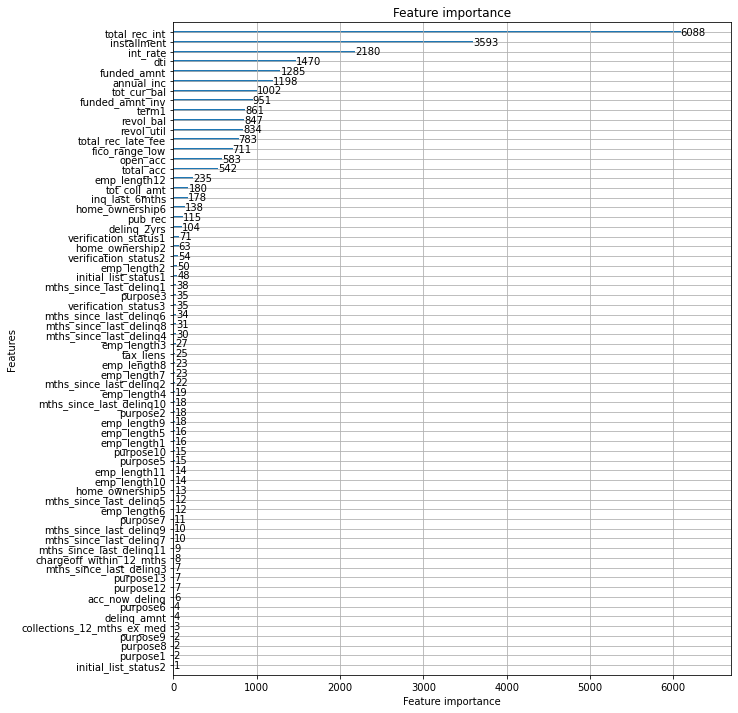

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_clf, ax=ax)

In [ ]:
!pip install -U pandas-profiling
import pandas_profiling
pr = df.profile_report()
pr.to_file('pr_report.html')